In [1]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp
import os
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import dataWrapper, provideData
from Utils.transform import cutOut


tfd = tfp.distributions
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)

Num GPUs: 1
Num GPUs Available: 1


Using TensorFlow backend.


In [2]:
output_dimension = (64,64)
input_channel    = 5
optimizer        = Adam( lr = 1e-3 )
# Pixel ausschneiden 
input_slices = [256,320,256,320]
cutOutFrame  = cutOut(input_slices)
PRETRAINING_TRANSFORMATIONS = [cutOutFrame]
years = [2015,2016,2017]
batch_size=400



train, test = provideData(dimension=output_dimension,
                          batch_size=batch_size,
                          transform=None,
                          channels = input_channel,
                          timeToPred = 5,
                          year = years,
                          preTransformation=PRETRAINING_TRANSFORMATIONS)

Found Year :  2015 => won't download this year again... please check for consistency
Found Year :  2016 => won't download this year again... please check for consistency
Found Year :  2017 => won't download this year again... please check for consistency
Finished Loading Dataset
 
[DEBUG] Data
[DEBUG] time to predict:  5
[DEBUG] Data
[DEBUG] time to predict:  5


In [3]:
def negative_Binomial_Unet(input_shape,
                           activation_hidden="relu",
                           activation_output="relu"):


    inputs = Input(shape=input_shape) 

    conv01 = Conv2D(10, kernel_size=(3, 3), padding="same")(inputs)       # 10 x 64x64
    conv01 = Activation(activation_hidden)(conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            # 10 x 32x32


    conv02 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv01_pool)  # 20 x 32x32
    conv02 = Activation(activation_hidden)(conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            # 20 x 16x16


    conv03 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv02_pool)  # 20 x 16x16
    conv03 = Activation(activation_hidden)(conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            # 20 x 8x8


    conv04 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv03_pool)  # 20 x 8x8
    conv04 = Activation(activation_hidden)(conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            # 20 x 4x4


    ### UPSAMPLING:
    up04 = UpSampling2D((2, 2))(conv04_pool)    # 20 x 8x8
    up04 = concatenate([conv04, up04], axis=3)  # 20+20 x 8x8


    up03 = UpSampling2D((2, 2))(up04)           # 40 x 16x16
    up03 = concatenate([conv03, up03], axis=3)  # 20+40 x 16x16


    up02 = UpSampling2D((2, 2))(up03)           # 60 x 32x32
    up02 = concatenate([conv02, up02], axis=3)  # 20+60 x 32x32


    up01 = UpSampling2D((2, 2))(up02)           # 80 x 64x64
    up01 = concatenate([conv01, up01], axis=3)  # 10+80 x 64x64

    
    output = Conv2D(2, (1, 1), activation="softplus")(up01)  # 1 x 64x64
    
    shape = tf.shape(output)
    shape = output.shape
    print(shape)
    
    max_count = output[:,:,:,:1]
    prob      = output[:,:,:,1:2]
    max_count = Flatten()(max_count)
    prob      = Flatten()(prob)
    prob      = Dense(64*64,activation="sigmoid")(prob)
    max_count = Dense(64*64,activation=tf.keras.activations.softplus)(max_count)
    prob      = tf.keras.layers.Reshape((64,64,1))(prob)
    max_count = tf.keras.layers.Reshape((64,64,1))(max_count)
    input_dist= tf.concat([max_count,prob],axis=-1)
    
    output_dist = tfp.layers.DistributionLambda(
        make_distribution_fn=lambda t: tfd.Independent(tfp.distributions.NegativeBinomial(
            total_count=t[..., :1], probs=t[..., 1:2] ),
            reinterpreted_batch_ndims=3
        #convert_to_tensor_fn=lambda s: s.sample(3)
    ))

    
    output = output_dist(input_dist)
    #output = tfp.layers.DistributionLambda(tfp.distributions.NegativeBinomial)([max_count,prob])
    model = Model(inputs=inputs, outputs=output)
    return model

In [4]:
trainer = Trainer(negative_Binomial_Unet,
                    lossfunction=NLL,
                    pathToData=(train,test),
                    batch_size = batch_size,
                    optimizer=optimizer,
                    dimension = output_dimension,
                    channels = input_channel,
                    metrics = ["mse","mae"])

(None, 64, 64, 2)
[Load file failed]  ./model_data/negative_Binomial_Unet_function/negative_Binomial_Unet_function64x64x5.h5
[Load file failed]  ./model_data/negative_Binomial_Unet_function/negative_Binomial_Unet_function64x64x5history.json
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 10)   460         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 10)   0           conv2d[0][0]                     
___________________________________________________

In [5]:
trainer.fit(20)


Epoch 1/20
591/591 [==============================] - ETA: 0s - loss: 5966.9365 - mse: 90.2515 - mae: 1.6387
Epoch 00001: val_loss improved from inf to 5469.42725, saving model to ./model_data/negative_Binomial_Unet_function/model-001-5966.936523-5469.427246.h5
591/591 [==============================] - 219s 370ms/step - loss: 5966.9365 - mse: 90.2515 - mae: 1.6387 - val_loss: 5469.4272 - val_mse: 19.7352 - val_mae: 1.3789
Epoch 2/20
591/591 [==============================] - ETA: 0s - loss: 5016.6592 - mse: 11.9535 - mae: 1.1887
Epoch 00002: val_loss improved from 5469.42725 to 5121.76514, saving model to ./model_data/negative_Binomial_Unet_function/model-002-5016.659180-5121.765137.h5
591/591 [==============================] - 219s 371ms/step - loss: 5016.6592 - mse: 11.9535 - mae: 1.1887 - val_loss: 5121.7651 - val_mse: 17.1952 - val_mae: 1.2895
Epoch 3/20
591/591 [==============================] - ETA: 0s - loss: 4856.8403 - mse: 13.8566 - mae: 1.1978
Epoch 00003: val_loss improved

591/591 [==============================] - ETA: 0s - loss: 4654.6924 - mse: 13.1493 - mae: 1.1441
Epoch 00020: val_loss improved from 4768.63330 to 4766.51025, saving model to ./model_data/negative_Binomial_Unet_function/model-020-4654.692383-4766.510254.h5
591/591 [==============================] - 221s 374ms/step - loss: 4654.6924 - mse: 13.1493 - mae: 1.1441 - val_loss: 4766.5103 - val_mse: 23.2894 - val_mae: 1.2823


In [6]:
import numpy as np
model = trainer.model
pred = None
label = None
pred_ = 20
test.on_epoch_end()
mean = []
stdev = []
label = []
for x,y in test:
    for i in range(batch_size):
        if y[i,:,:,:].max() > 0:
            pred = model(np.array([x[i,:,:,:]]))
            mean.append(pred.mean())
            stdev.append(pred.stddev())
            label.append(y[i,:,:,:])
    if len(label) >= pred_:
        break

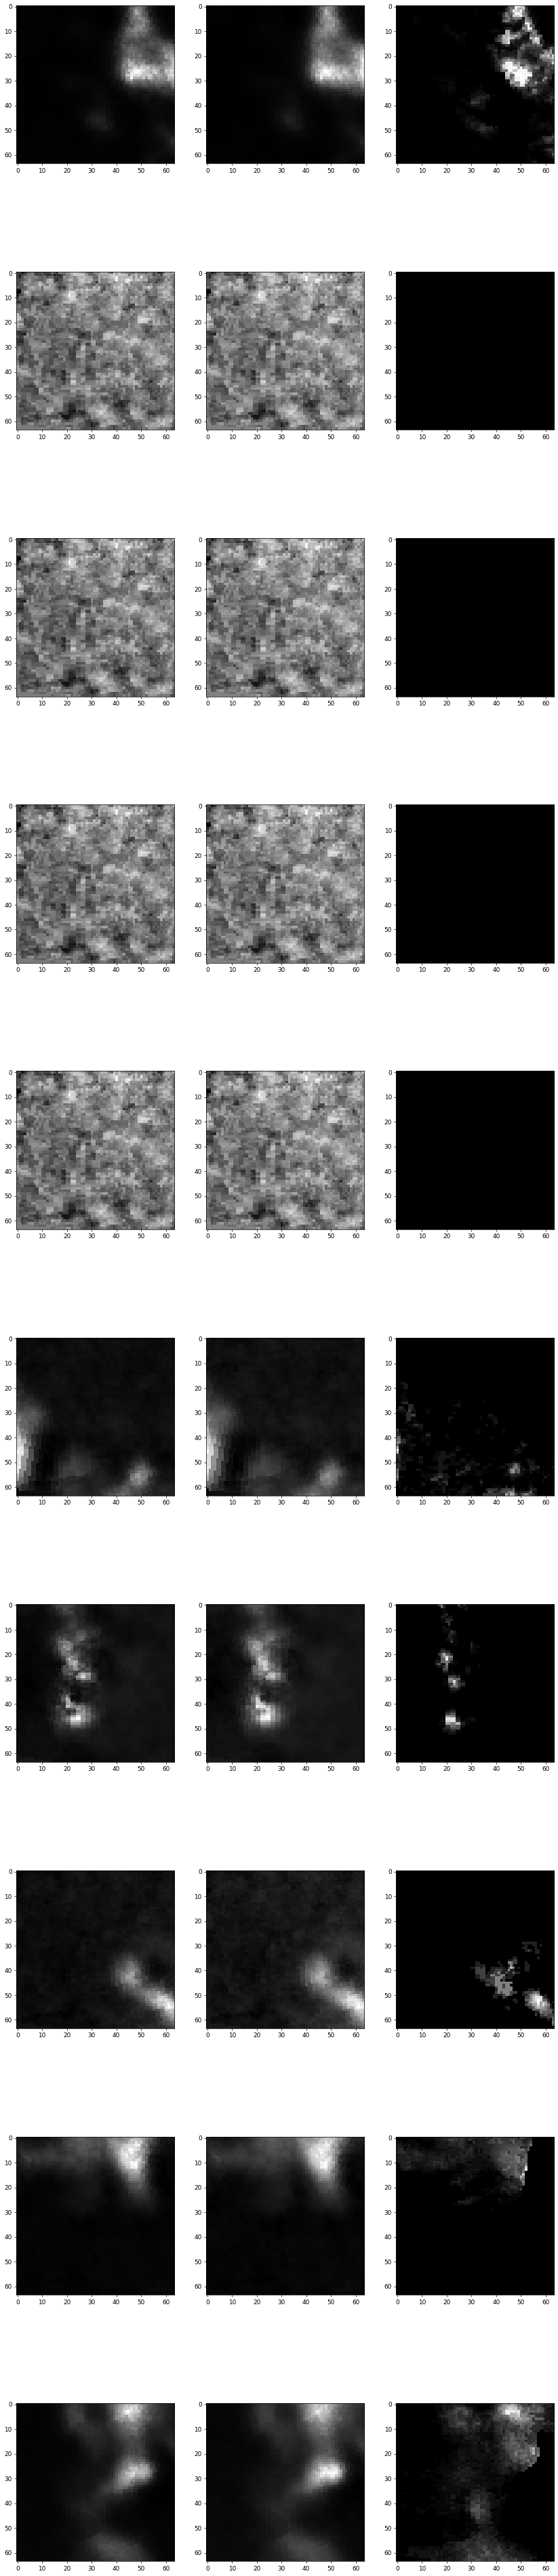

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
fig, axes = plt.subplots(10, 3, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
for batch,img in enumerate(mean):
    if batch == 10:
        break
    axes[batch,0].imshow(img[0,:,:,0],cmap="gray")
    axes[batch,1].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,2].imshow(label[batch][:,:,0],cmap="gray")